In [110]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [111]:
history_df = pd.read_json('data/streaming_history.json')
# print(history_df.head())

In [112]:
history_df.to_csv('data/streaming_history.csv', index=False)
print(history_df.shape)

(13509, 21)


In [113]:
history_df.info()
# We can probably drop episode name, episode show name and episode uri

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13509 entries, 0 to 13508
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ts                                 13509 non-null  object 
 1   username                           13509 non-null  object 
 2   platform                           13509 non-null  object 
 3   ms_played                          13509 non-null  int64  
 4   conn_country                       13509 non-null  object 
 5   ip_addr_decrypted                  13509 non-null  object 
 6   user_agent_decrypted               11607 non-null  object 
 7   master_metadata_track_name         13402 non-null  object 
 8   master_metadata_album_artist_name  13402 non-null  object 
 9   master_metadata_album_album_name   13402 non-null  object 
 10  spotify_track_uri                  13402 non-null  object 
 11  episode_name                       20 non-null     obj

In [114]:
spotify_stream_df = history_df[[
    'ts', 'ms_played', 'master_metadata_track_name', 'master_metadata_album_artist_name']].copy()
# spotify_stream_df.tail(3)
spotify_stream_df['ts'] = pd.to_datetime(spotify_stream_df['ts']) # convert to datetime

spotify_stream_df.sample(10)

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name
8782,2024-02-24 05:03:38+00:00,221538,Ps & Qs,Lil Uzi Vert
665,2023-04-29 23:46:08+00:00,1647,Still D.R.E.,Dr. Dre
2213,2023-06-21 05:15:55+00:00,226360,bread & butter,Gunna
7090,2024-01-05 22:08:03+00:00,10449,20 Min,Lil Uzi Vert
3403,2023-09-18 03:37:19+00:00,193386,Kiss Me Thru The Phone,Soulja Boy
1833,2023-06-09 04:40:41+00:00,26227,West Coast Weekend,Tyga
1863,2023-06-10 03:28:42+00:00,8750,All My Life (feat. J. Cole),Lil Durk
11560,2024-05-21 15:16:20+00:00,223173,TOPIA TWINS (feat. Rob49 & 21 Savage),Travis Scott
4417,2023-10-22 17:00:49+00:00,21841,BAD!,XXXTENTACION
10436,2024-04-16 18:16:59+00:00,3065,Summertime In Paris,Jaden


In [115]:
# Unique artists and tracks:
print("Unique Artists: ", len(spotify_stream_df["master_metadata_album_artist_name"].unique()))
print("Unique Tracks: ", len(spotify_stream_df["master_metadata_track_name"].unique()))


Unique Artists:  780
Unique Tracks:  2901


In [116]:
spotify_stream_df['play_time'] = pd.to_datetime(spotify_stream_df['ts'])
spotify_stream_df['year'] = pd.DatetimeIndex(spotify_stream_df['play_time']).year
spotify_stream_df['month'] = pd.DatetimeIndex(spotify_stream_df['play_time']).month
spotify_stream_df['day'] = pd.DatetimeIndex(spotify_stream_df['play_time']).day
spotify_stream_df['weekday'] = pd.DatetimeIndex(spotify_stream_df['play_time']).weekday
spotify_stream_df['hour'] = pd.DatetimeIndex(
    spotify_stream_df['play_time']).hour
spotify_stream_df['minute'] = pd.DatetimeIndex(
    spotify_stream_df['play_time']).minute
spotify_stream_df['time'] = pd.DatetimeIndex(spotify_stream_df['play_time']).time
spotify_stream_df['day-name'] = spotify_stream_df['play_time'].apply(lambda x: x.day_name())
spotify_stream_df['count'] = 1

In [117]:
spotify_stream_df['time_played'] = pd.to_timedelta(spotify_stream_df['ms_played'], unit='ms')

def hours_played(time):
    return time.seconds / 3600
def minutes_played(time):
    return time.seconds / 60 % 60


spotify_stream_df["time_played_hours"] = spotify_stream_df["time_played"].apply(
    hours_played).round(3)
spotify_stream_df["time_played_minutes"] = spotify_stream_df["time_played"].apply(
    minutes_played).round(3)

In [118]:
spotify_stream_df.tail()

,ts,ms_played,master_metadata_track_name,master_metadata_album_artist_name,play_time,year,month,day,weekday,hour,minute,time,day-name,count,time_played,time_played_hours,time_played_minutes
13504,2024-06-12 22:14:27+00:00,5189,That Fiya,Lil Uzi Vert,2024-06-12 22:14:27+00:00,2024,6,12,2,22,14,22:14:27,Wednesday,1,0 days 00:00:05.189000,0.001,0.083
13505,2024-06-12 22:14:30+00:00,3157,5!RE,Homixide Gang,2024-06-12 22:14:30+00:00,2024,6,12,2,22,14,22:14:30,Wednesday,1,0 days 00:00:03.157000,0.001,0.050
13506,2024-06-12 22:16:20+00:00,110926,Go,Ken Carson,2024-06-12 22:16:20+00:00,2024,6,12,2,22,16,22:16:20,Wednesday,1,0 days 00:01:50.926000,0.031,1.833
13507,2024-06-12 22:19:33+00:00,192213,"Like This (feat. Lil Uzi Vert, Destroy Lonely)",Ken Carson,2024-06-12 22:19:33+00:00,2024,6,12,2,22,19,22:19:33,Wednesday,1,0 days 00:03:12.213000,0.053,3.200
13508,2024-06-12 23:42:58+00:00,113030,Fighting My Demons,Ken Carson,2024-06-12 23:42:58+00:00,2024,6,12,2,23,42,23:42:58,Wednesday,1,0 days 00:01:53.030000,0.031,1.883


In [119]:
# no longer necessary
spotify_stream_df.drop(columns=['time_played', 'ms_played'])
# All data cleaning is complete
spotify_stream_df.describe()

,ms_played,year,month,day,weekday,hour,minute,count,time_played,time_played_hours,time_played_minutes
count,1.350900e+04,13509.000000,13509.000000,13509.000000,13509.000000,13509.000000,13509.000000,13509.0,13509,13509.000000,13509.000000
mean,9.868708e+04,2023.445111,6.052558,15.119846,2.994892,11.510252,29.201125,1.0,0 days 00:01:38.687077429,0.027267,1.636687
std,9.559666e+04,0.619885,3.308833,8.660908,2.018581,8.555303,17.131212,0.0,0 days 00:01:35.596663713,0.026561,1.593050
min,0.000000e+00,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.0,0 days 00:00:00,0.000000,0.000000
25%,5.320000e+03,2023.000000,4.000000,8.000000,1.000000,3.000000,15.000000,1.0,0 days 00:00:05.320000,0.001000,0.083000
50%,8.953500e+04,2023.000000,6.000000,14.000000,3.000000,14.000000,29.000000,1.0,0 days 00:01:29.535000,0.025000,1.483000
75%,1.708580e+05,2024.000000,9.000000,23.000000,5.000000,20.000000,44.000000,1.0,0 days 00:02:50.858000,0.047000,2.833000
max,1.648635e+06,2024.000000,12.000000,31.000000,6.000000,23.000000,59.000000,1.0,0 days 00:27:28.635000,0.458000,27.467000


In [120]:
sns.set_style('whitegrid')
# print(plt.style.available)
plt.style.use('seaborn-v0_8-whitegrid')

matplotlib.rcParams['figure.figsize'] = (10, 5)
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.facecolor'] = '#00000000'

In [121]:
# calculating average songs per artist
total_artists = spotify_stream_df['master_metadata_album_artist_name'].count()
unique_artists = spotify_stream_df['master_metadata_album_artist_name'].nunique()

average_songs_per_artist = total_artists / unique_artists
print(average_songs_per_artist)

17.20410783055199


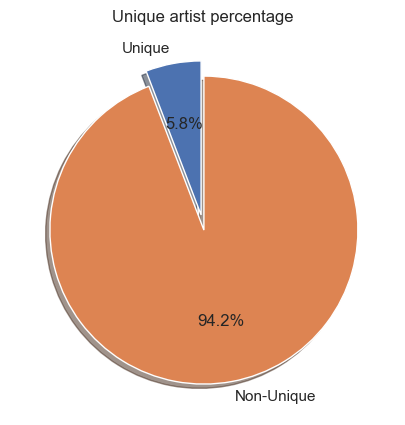

In [122]:
unique_artist_list = np.array([unique_artists, total_artists - unique_artists])
unique_artist_labels = ['Unique', 'Non-Unique']

fig, ax = plt.subplots()
ax.pie(unique_artist_list, labels=unique_artist_labels, autopct='%1.1f%%', startangle=90, shadow=True, explode = [0.05, 0.05])
plt.title("Unique artist percentage")
plt.show()

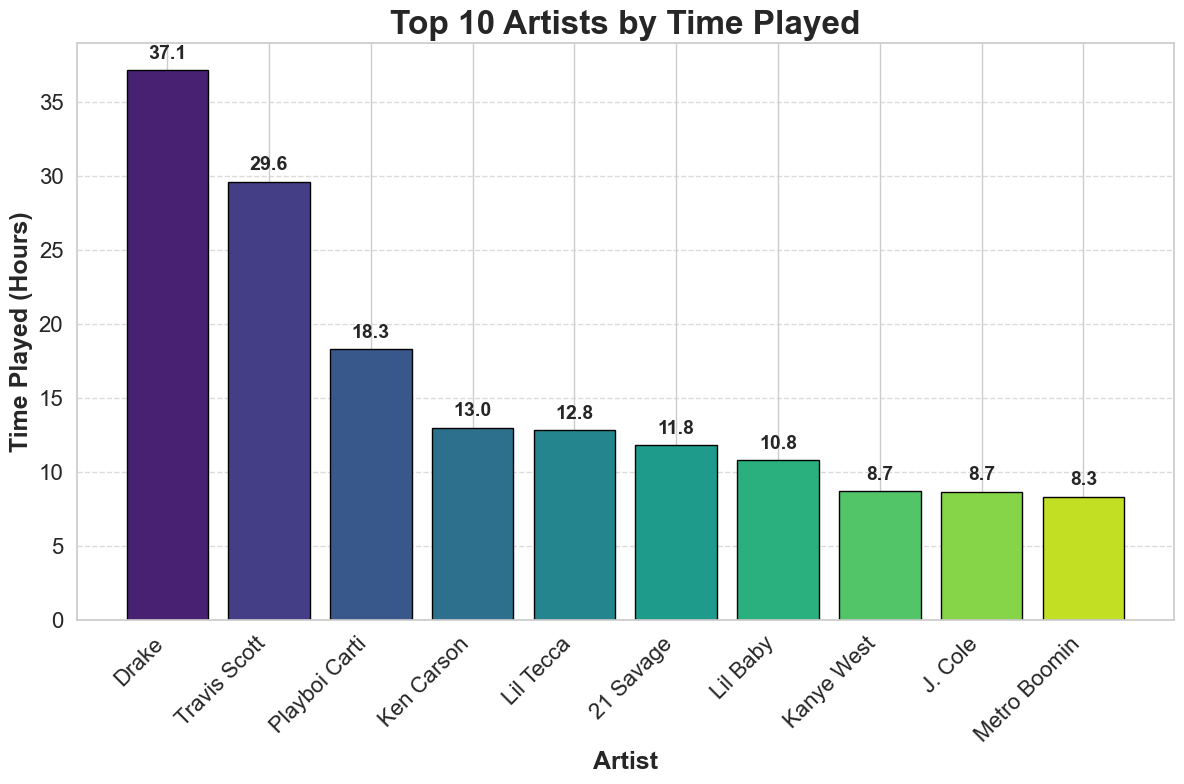

In [123]:
top_artists = spotify_stream_df.groupby(['master_metadata_album_artist_name'])[
    ['count', 'time_played_hours']].sum().sort_values(by='time_played_hours', ascending=False)
top_10_artists = top_artists.head(10)

# Set plot style and color palette
sns.set_theme(style="whitegrid")
palette = sns.color_palette("viridis", len(top_10_artists))

plt.figure(figsize=(12, 8))
bars = plt.bar(top_10_artists.index,
               top_10_artists['time_played_hours'],
               color=palette,
               edgecolor='black')

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 1),
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Improve labels and title
plt.xlabel('Artist', fontsize=18, fontweight='bold')
plt.ylabel('Time Played (Hours)', fontsize=18, fontweight='bold')
plt.title('Top 10 Artists by Time Played', fontsize=24, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)

# Show gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

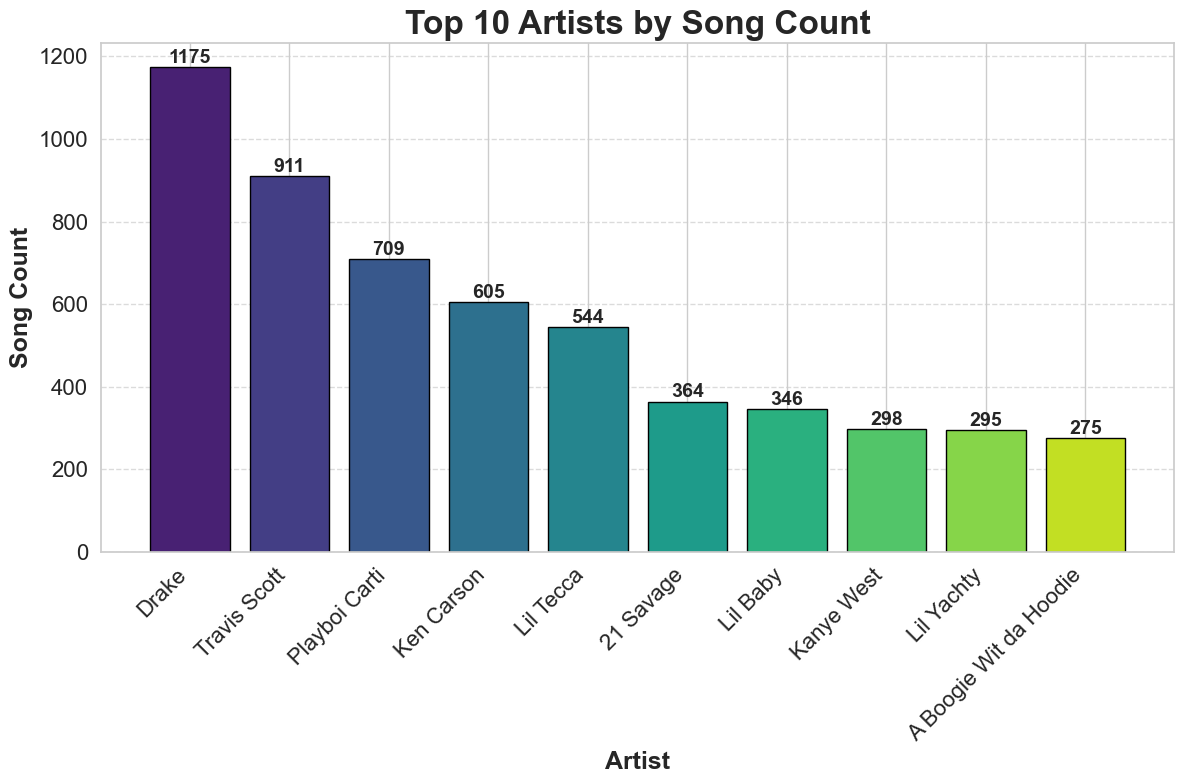

In [124]:
top_artist_counts = spotify_stream_df.groupby(['master_metadata_album_artist_name'])[
    ['count', 'time_played_hours']].sum().sort_values(by='count', ascending=False)
top_10_artist_counts = top_artist_counts.head(10)

# Set plot style and color palette
sns.set_theme(style="whitegrid")
palette = sns.color_palette("viridis", len(top_10_artists))

plt.figure(figsize=(12, 8))
bars = plt.bar(top_10_artist_counts.index,
               top_10_artist_counts['count'],
               color=palette,
               edgecolor='black')

# Add data labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, round(yval, 1),
             ha='center', va='bottom', fontsize=14, fontweight='bold')

# Improve labels and title
plt.xlabel('Artist', fontsize=18, fontweight='bold')
plt.ylabel('Song Count', fontsize=18, fontweight='bold')
plt.title('Top 10 Artists by Song Count', fontsize=24, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=16)
plt.yticks(fontsize=16)

# Show gridlines for y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

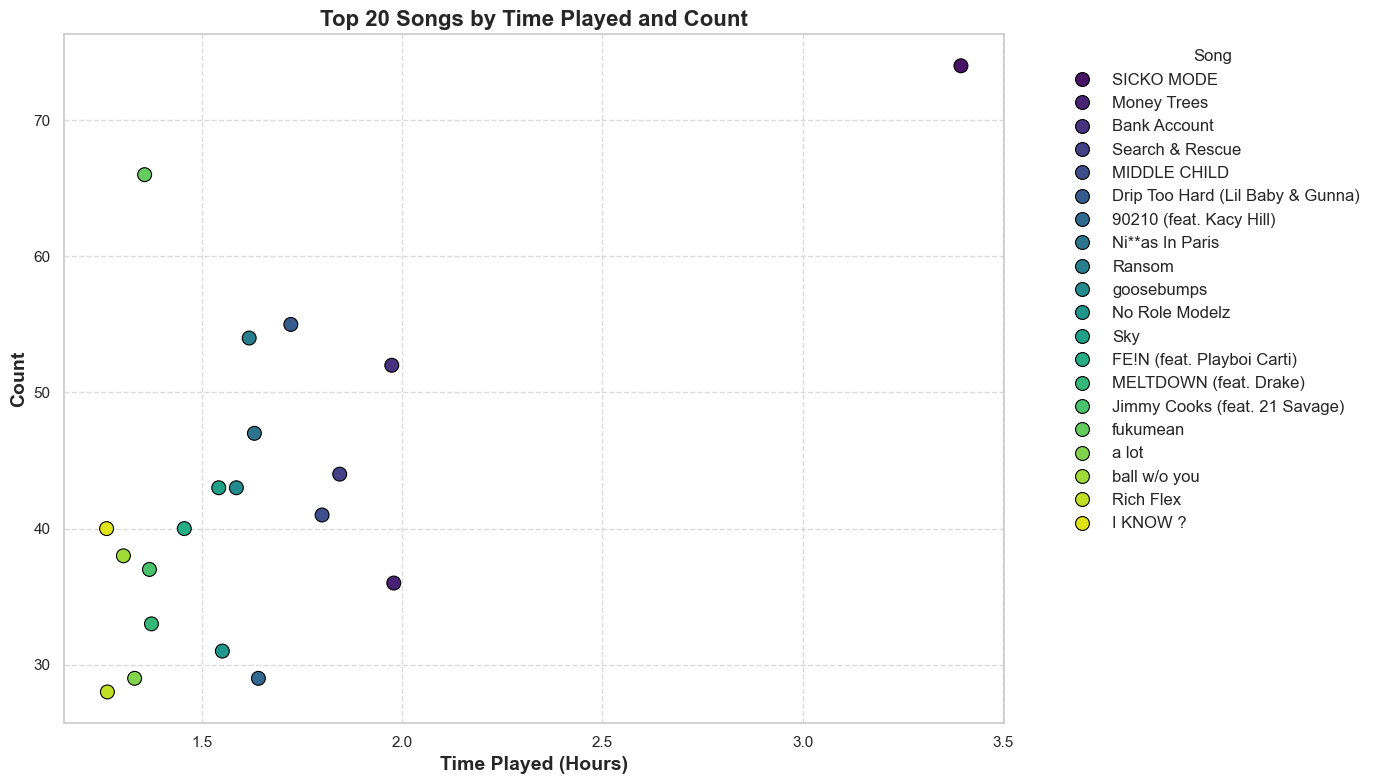

In [125]:
# Calculate top songs
top_songs = spotify_stream_df.groupby(['master_metadata_track_name'])[
    ['count', 'time_played_hours']].sum().sort_values(by='time_played_hours', ascending=False)
top_20_songs = top_songs.head(20).reset_index()

plt.figure(figsize=(14, 8))

# Create scatter plot
sns.scatterplot(data=top_20_songs, x='time_played_hours', y='count',
                hue='master_metadata_track_name', palette='viridis', s=100, edgecolor='black')

plt.xlabel('Time Played (Hours)', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Top 20 Songs by Time Played and Count',
          fontsize=16, fontweight='bold')
plt.legend(title='Song', bbox_to_anchor=(
    1.05, 1), loc='upper left', fontsize=12)

plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

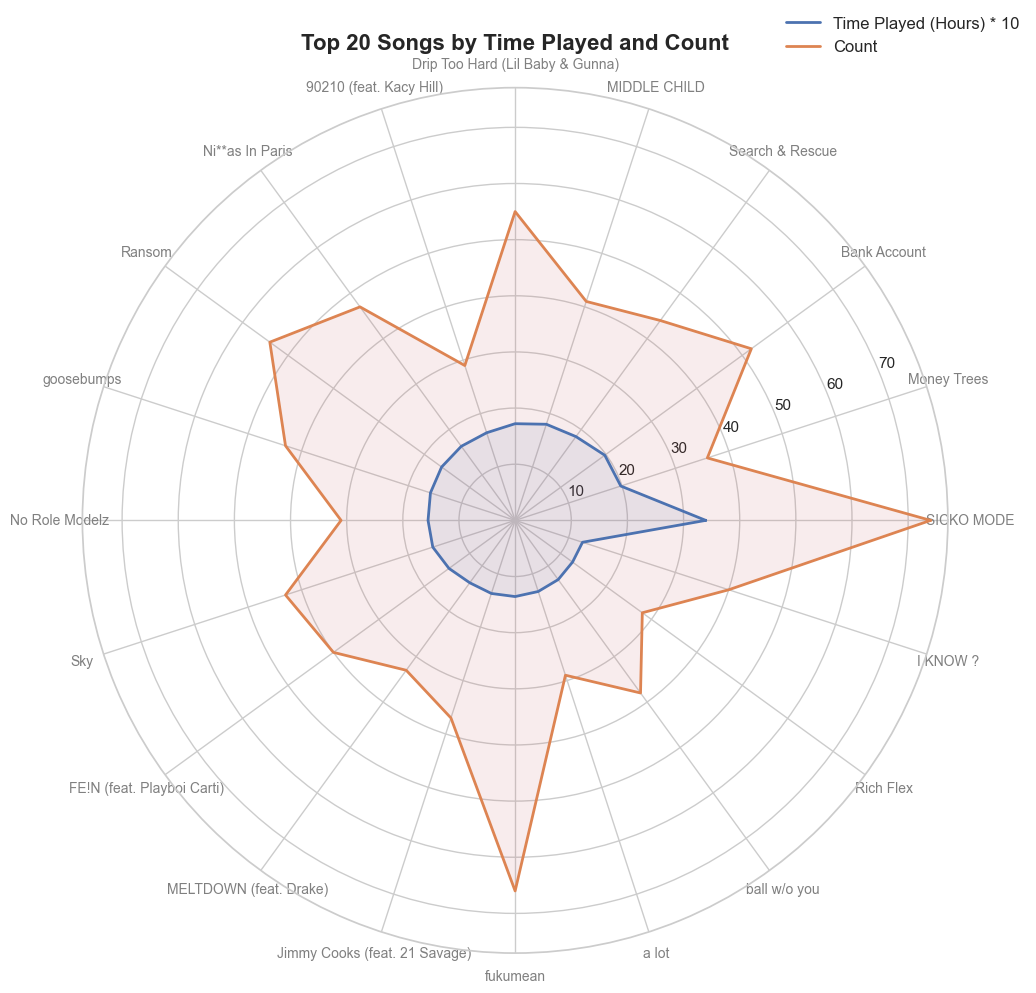

In [126]:
from math import pi
import matplotlib.pyplot as plt

top_songs = spotify_stream_df.groupby(['master_metadata_track_name'])[
    ['count', 'time_played_hours']].sum().sort_values(by='time_played_hours', ascending=False)
top_20_songs = top_songs.head(20).reset_index()

# Prepare data for radar chart
labels = top_20_songs['master_metadata_track_name']
num_vars = len(labels)

# Compute angle for each axis
angles = [n / float(num_vars) * 2 * pi for n in range(num_vars)]
angles += angles[:1]

# Radar chart data
time_played_scaled = (top_20_songs['time_played_hours'] * 10).tolist()
time_played_scaled += time_played_scaled[:1]
count = top_20_songs['count'].tolist()
count += count[:1]

plt.figure(figsize=(12, 10))

ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], labels, color='grey', size=10)
ax.plot(angles, time_played_scaled, linewidth=2,
        linestyle='solid', label='Time Played (Hours) * 10')
ax.fill(angles, time_played_scaled, 'b', alpha=0.1)

ax.plot(angles, count, linewidth=2, linestyle='solid', label='Count')
ax.fill(angles, count, 'r', alpha=0.1)

plt.title('Top 20 Songs by Time Played and Count',
          size=16, fontweight='bold', position=(0.5, 1.1))
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize=12)
plt.tight_layout()
plt.show()

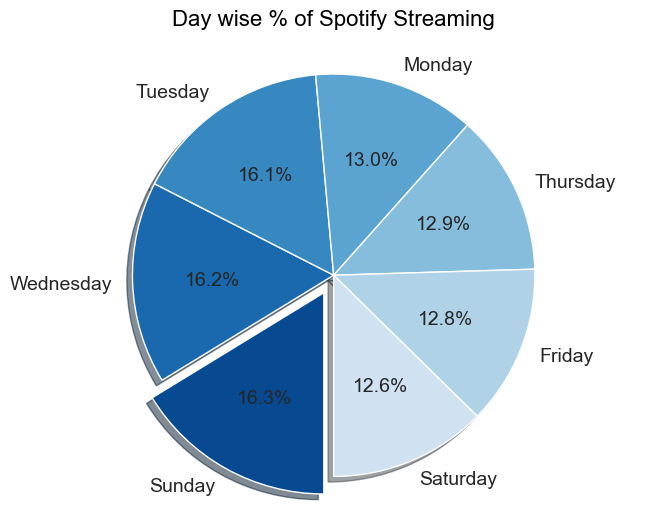

In [127]:
import matplotlib.cm as cm

day_name_counts = spotify_stream_df["day-name"].value_counts()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
colors = cm.Blues(np.linspace(0.9, 0.2, len(day_name_counts)))

# Get the maximum index
max_index = day_name_counts.argmax()

# Create an explode list
explode = [0] * len(day_name_counts)
explode[max_index] = 0.1

# Plot the pie chart
ax.pie(day_name_counts, labels=day_name_counts.index, colors=colors, autopct='%1.1f%%', startangle=-90,
       textprops={'fontsize': 14}, explode=explode, shadow=True, counterclock=False)

# Set the title and axis aspect ratio
ax.set_title('Day wise % of Spotify Streaming', pad=20, fontdict={
             'color': 'black', 'weight': 'normal', 'size': 16})
ax.axis('equal')

plt.show()

C:\Users\Parthiv\AppData\Local\Temp\ipykernel_36692\1405844189.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  filtered_df['year_month'] = filtered_df['ts'].dt.to_period('M')
C:\Users\Parthiv\AppData\Local\Temp\ipykernel_36692\1405844189.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['year_month'] = filtered_df['ts'].dt.to_period('M')


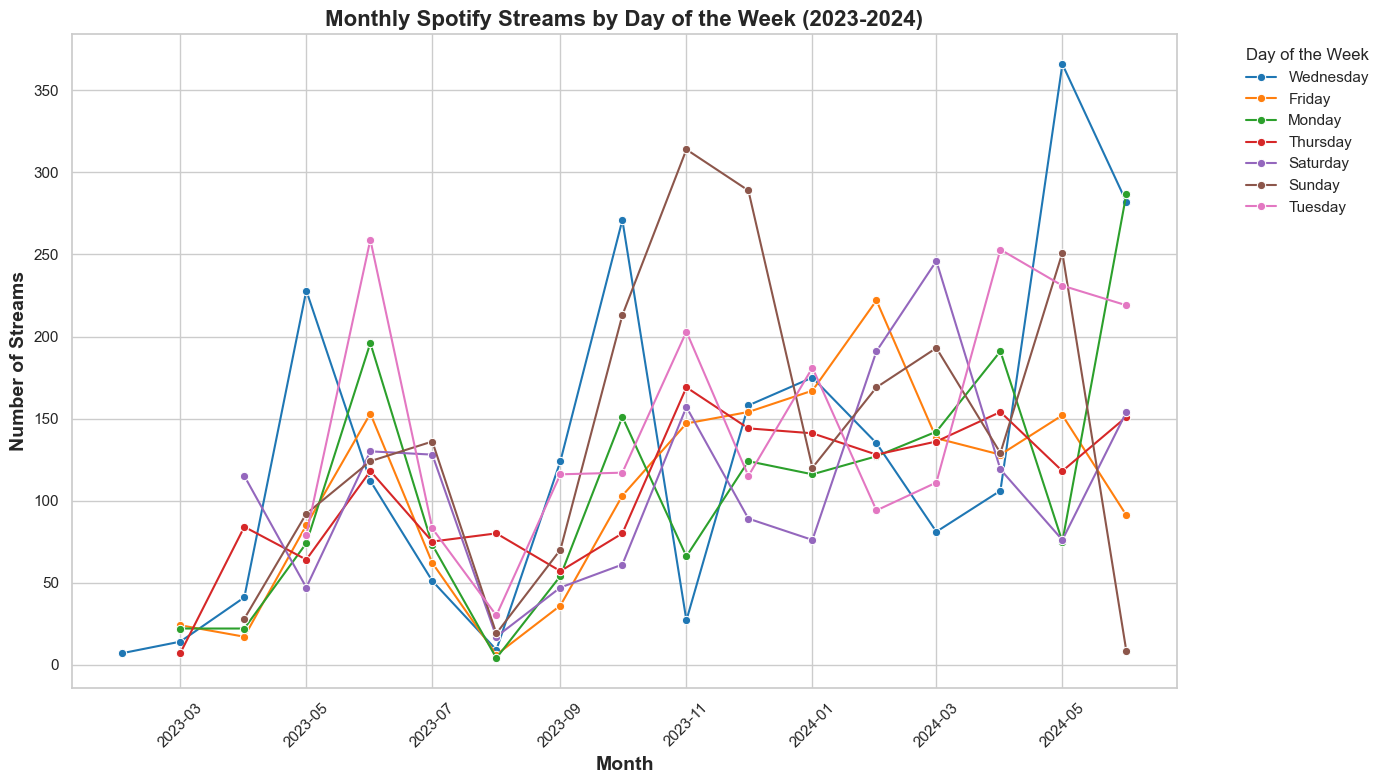

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'ts' column is in datetime format
spotify_stream_df['ts'] = pd.to_datetime(spotify_stream_df['ts'])

# Filter data for the years 2023 and 2024
filtered_df = spotify_stream_df[spotify_stream_df['ts'].dt.year.isin([
                                                                     2023, 2024])]

# Extract month and year
filtered_df['year_month'] = filtered_df['ts'].dt.to_period('M')

# Aggregate data by month
monthly_streams = filtered_df.groupby(
    ['year_month', 'day-name']).size().reset_index(name='count')

# Convert 'year_month' back to datetime for plotting
monthly_streams['year_month'] = monthly_streams['year_month'].dt.to_timestamp()

plt.figure(figsize=(14, 8))
sns.lineplot(data=monthly_streams, x='year_month', y='count',
             hue='day-name', marker='o', palette='tab10')

plt.title('Monthly Spotify Streams by Day of the Week (2023-2024)',
          fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=14, fontweight='bold')
plt.ylabel('Number of Streams', fontsize=14, fontweight='bold')
plt.legend(title='Day of the Week', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Average Distribution of Streaming Over Day Hours'}, xlabel='Hours (in 24 hour format)', ylabel='Songs Played'>

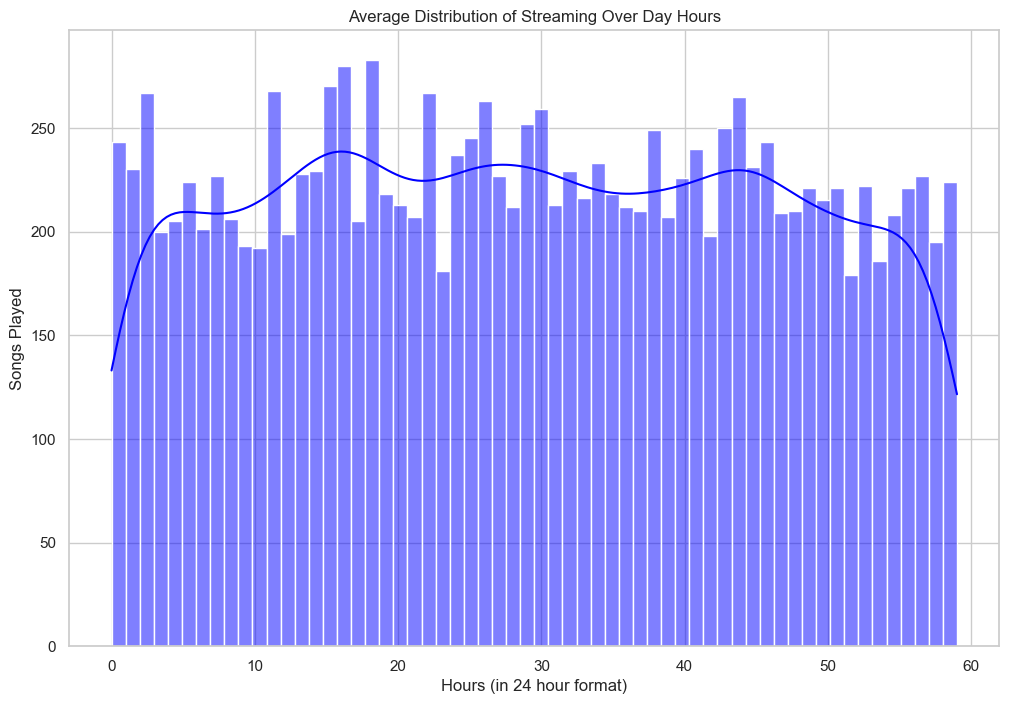

In [135]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set(title="Average Distribution of Streaming Within an Hour",
       xlabel="Minute (0-59)", ylabel="Songs Played")
sns.histplot(spotify_stream_df["minute"], bins=60, kde=True, color="blue")

<Axes: title={'center': 'Average Distribution of Streaming Over Day Hours'}, xlabel='Hours (in 24 hour format)', ylabel='Songs Played'>

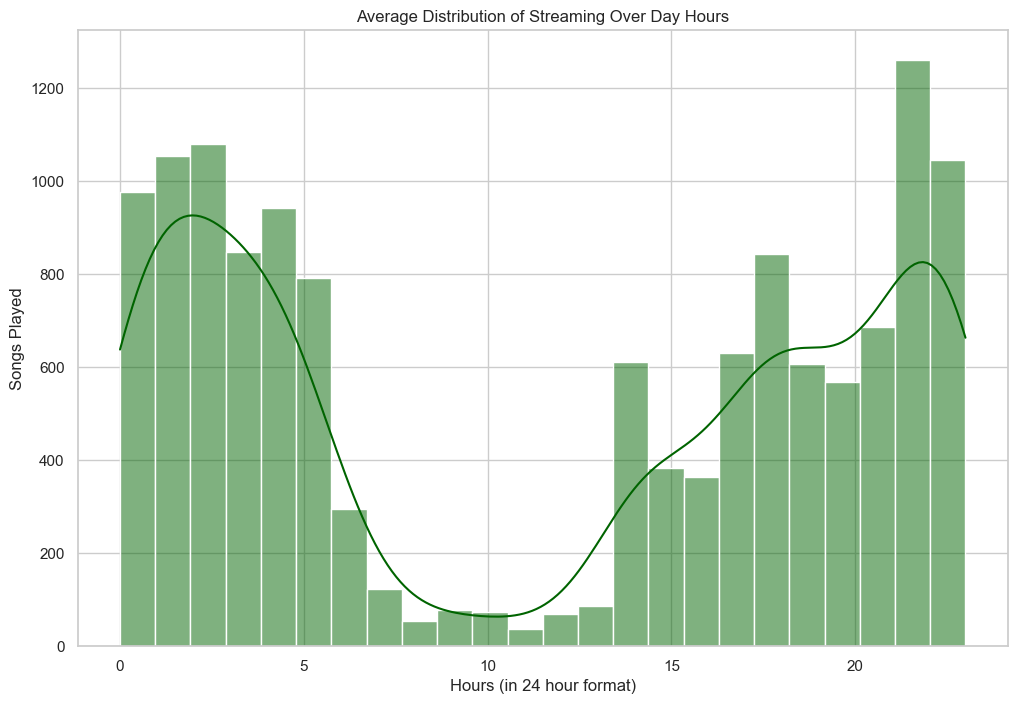

In [132]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.set(title="Average Distribution of Streaming Over Day Hours",
       xlabel="Hours (in 24 hour format)", ylabel="Songs Played")
sns.histplot(spotify_stream_df["hour"], bins=24, kde=True, color="darkgreen")

In [136]:
spotify_stream_df['time_played_hours'].sum()

368.35600000000005

In [140]:
date_df = spotify_stream_df['play_time']
time_difference = (date_df.iloc[10803] -
                   date_df.iloc[0]) / np.timedelta64(1, "D")
time_difference_hours = time_difference*24
time_difference_hours

29634.448055555553

In [144]:
total_songs = spotify_stream_df["master_metadata_track_name"].count()
total_songs / time_difference

10.853854925760995